In [4]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Single Lane Simulation

## Rules for updating the simulation
- Acceleration to v_max (value 5): if *v*  of a vehical is lower than v_max and the distance to next car is larger than v+1, the speed will be v→v+1
- Slowing down: if next vehicle at site i +j (with j ≤v), it reduces speed to j-1
- Randomization: with prob p, for v >0, do v→ v-1
- Car motion: move vehical, *v sites*

# Multi Lane Simulation

## Rules for Simulation

-   Change lanes
    - gap(i) < l (Check in same lane: l = v + 1)
    - gap_o(i) < lo (Check ahead in other lane: lo = v+1)
    - gap_o_back(i) < lo_back (Check back in other lane: lo_back = max_v)
    - rand() < p_change (Change only if less than probability of change
-   Independent single lane update
    - If v < V_max, v = v + 1
    - If v > gap, v = gap
    - If v > 0, rand < p_break; v = v - 1

In [65]:
DISPLAY = True

class Car:
    '''
        Simulates a car in the simulation
    '''
    
    def __init__(self, speed=1, v_max=5, p_slow=0.5, object_type='car', gap_other_back=None):
        '''
            Initialize initial parameters
            
            Input:
            
            * speed (int) The current speed of the car
            
            * max_speed (int) The maximum speed of the car
            
            * p_slow (float) Probability of slowing down
        '''
        self.speed = speed
        self.v_max = v_max
        self.p_slow = p_slow
        self.object_type = object_type
        
        self.gap_ahead = self.speed + 1
        self.gap_other_ahead = self.speed + 1
        
        if gap_other_back == None:
            self.gap_other_back = v_max
        
    def set_speed(self, speed):
        '''
            Updates the speed of the car and changes the range for its neighborhood in front
            
            Input:
            
            * speed (int) The updated speed of the car
        '''
        self.speed = speed
        self.gap_ahead = self.speed + 1
        self.gap_other_ahead = self.speed + 1
    
    def set_gap_other_back(self, gap):
        '''
            Updates the number of steps the driver will look back before changing lanes
            
            Input:
            
            * speed (int) The gap to check for cars in other lane behind the car.
        '''
        self.gap_other_back = gap
        
        
        
class TrafficSimulation:
    '''
        Simulates the traffic flow in a high way using periodic boundary
        
        Attributes:
        ----------------
        * road_length -- The length of the road.
        
        * traffic_density -- The proportion of car per unit length of road
        
        * v_max -- The maximum speed of the car on the road
        
        * p_slow -- The probability of randomly slowing down
        
        * num_lanes -- The number of lanes in the simulation
        
        * p_change -- The probability of changing lanes
        
        * current_state -- (Array) stores current speed and position of cars
        
        * next_state -- (Array) stores next moving location of each cars
        
        * arr_flow -- (Array) stores the flow of cars in each time step
        
        
        Methods:
        ------------------
        * __init__ -- Initializes the attributes
        
        * initialize() -- Initializes all parameters for the simulation
        
        * step() -- Perform the updates for single time step
        
        * _update_speed() -- Updates the speed of cars in each lane based on their gaps ahead
        
        * _update_lanes() -- Updates the lanes of the cars. Moves them to new lane if there are free side lanes
        
        * _get_lane() -- Returns the index of the free lane to place the car
        
        * _check_free_lane -- Checks whether or not a lane is empty.
        
        * calc_flow() --  Calculate and stores the flow of cars after each time step
        
        * calc_avg_flow() -- Calculates the average flow of cars during the simulation
        
        * display() -- Displays the next state of the cars
    '''
    
    def __init__(self, road_length=100, traffic_density=0.3, v_max=5, p_slow=0.5, 
                 num_lanes=2, p_change=1):
        '''
            Initializes variables and attributes for the simulation
            
            Inputs
            
            * road_length (int) The length of the road for the simulation. Default: 100
            
            * traffic_density (float) The proportion of the road covered by cars. Default: 0.03
            
            * v_max (int) The maximum speed of the car. Default: 5
            
            * num_lanes (int) The number of lanes in
            
            * p_slow (float) The probability of a car slowing down
            
            * p_change (float) The probability of changin lanes
        '''
        
        self.road_length = road_length
        self.traffic_density = traffic_density
        self.v_max = v_max
        self.p_slow = p_slow
        self.num_lanes = num_lanes
        self.p_change = p_change
    
        self.initialize()
        
    
    def initialize(self):
        '''
            Creates a random distribution of cars for initializing the simulation.
            Assumes both lanes have same traffic density.
        '''
        states = [[-1 for _ in range(self.road_length)] for _ in range(self.num_lanes)]
        self.arr_flow = []
        
        for lane in states:
            cars = np.random.choice(self.road_length, replace=False, 
                        size=int(round(self.road_length * self.traffic_density)))
            
            for ind_car in cars:
                lane[ind_car] = Car(np.random.randint(0, self.v_max + 1), 
                                    self.v_max, self.p_slow, self.v_max) 
        
        self.current_state = np.array(states)

        
    
    def step(self):
        '''
            Updates simulation by one time step following all the rules.
        '''
        
        if self.num_lanes > 1:
            # If there are more than one lanes, then check for lane changes.
            self._update_lanes()
        
        # Updating the speed independently
        self._update_speed()
        
        
        if DISPLAY:
            self.display()
            
        self.calc_flow()
    
    def _update_lanes(self):
        '''
            Checks the free side lanes for all the cars, and move them to other lanes if side lanes
            are free.
        '''
        
        # Array to store the temporary lane switches
        temp_state = [[-1 for _ in range(self.road_length)] for _ in range(self.num_lanes)]
        num_lane_changes = 0

        for ind_lane in range(self.num_lanes):
                arr_ind_cars = np.where(self.current_state[ind_lane] != -1)[0]

                for ind_car in arr_ind_cars:
                    new_lane = self._get_lane(ind_lane, ind_car)
                    
                    # Checking if two cars collide in the same place
                    # The priority would go to cars in lower lanes or to the left as 
                    # we loop throught that lane in the beginning
                    if temp_state[new_lane][ind_car] == -1:
                        temp_state[new_lane][ind_car] = self.current_state[ind_lane, ind_car]
                    else:
                        temp_state[ind_lane][ind_car] = self.current_state[ind_lane, ind_car]
                        
                    # counting number of lane changes per step
                    if new_lane != ind_lane:
                        num_lane_changes += 1
        
        if DISPLAY:
            print('Number of lane changes in this step: ', num_lane_changes)
        self.current_state = np.array(temp_state)
    
    
    def _get_lane(self, ind_lane, ind_car):
        '''
            Gets the preferred lane to move
            
            Input:
            
            * ind_lane (int) The index of lane the car is currently on
            
            * ind_car (int) The index of the cell of the car in the lane
            
            Output:
            
            (int) The new or updated index for the car to change lanes.
        '''
        
        lane_options = [] #stores the indexes of side lanes
        
        # Checking the boundary conditions
        if ind_lane > 0:
            lane_options.append(ind_lane - 1)
        
        if ind_lane != self.num_lanes - 1:
            lane_options.append(ind_lane + 1)
            
        free_lanes = [] #stores the free lanes
        for ind_other_lane in lane_options:
            if self._check_free_lane(ind_lane, ind_car, ind_other_lane):
                free_lanes.append(ind_other_lane)
        
        # If there are two free lanes, it will randomly choose one of the lanes
        if len(free_lanes) > 0:
            return np.random.choice(free_lanes)
        
        return ind_lane
            
        
        
    def _check_free_lane(self, ind_lane, ind_car, ind_other_lane):
        '''
            Check for changing lanes
            
            Input:
            
            * ind_lane: Index of the lane the car is currently on
            
            * ind_car: The index of the car in the given lane
            
            * ind_other_lane: The index of the side lane to test for being free
            
            Output:
            
            * (bool) Whether or not the chosen lane is free or not
        '''
        car = self.current_state[ind_lane][ind_car]
        
        car_ahead = False
        # Check gap at front :gap(i) < l
        for gap in range(1, car.gap_ahead + 1):
            if self.current_state[ind_lane][(ind_car + gap) % self.road_length] != -1:
                car_ahead = True
        
        if not car_ahead:
            return False
        
        # Check in other lane next to the car
        if self.current_state[ind_other_lane][ind_car] != -1:
            return False
        
        # Check gap at front in other lane: gap_o(i) < lo
        for gap in range(1, car.gap_other_ahead + 1):
            if self.current_state[ind_other_lane][(ind_car + gap) % self.road_length] != -1:
                return False
            
        # Check gap at the back in other lane: gap_o_back(i) <lo_back
        for gap in range(1, car.gap_other_back + 1):
            if self.current_state[ind_other_lane][ind_car - gap] != -1:
                return False
        
        # Check for lane change probability
        if np.random.uniform() < self.p_change:
            return True
        
        return False
    
    
    def _update_speed(self):
        '''
            Follows the independent update rule to update the velocity of the car and move them in each lane
            at a time.
        '''
        next_state = []
        
        for lane in self.current_state:
            arr_ind_cars = np.where(lane != -1)[0]
        
            for i in arr_ind_cars:
                
                # Accelerate if speed < v_max
                if lane[i].speed < lane[i].v_max:
                    lane[i].speed += 1

                # Decelerate based on neighborhood
                for gap in range(1, lane[i].speed + 1):
                    if lane[(i + gap) % self.road_length] != -1:
                        gap = gap - 1
                        break
                lane[i].speed = gap

                # Randomized slow downs
                if (np.random.uniform() < lane[i].p_slow) and (lane[i].speed > 0):
                    lane[i].speed -= 1
        
            next_step_lane = [-1 for _ in range(self.road_length)]
            for i in arr_ind_cars:
                next_step_lane[(i + lane[i].speed) % self.road_length] = lane[i]
                
            next_state.append(next_step_lane)
        
        self.current_state = np.array(next_state)
    
    
    
    def calc_flow(self):
        '''
            Stores the flow of cars at each time step
        '''
        counter = 0
        for lane in self.current_state:
            for i in range(self.v_max):
                if lane[i] != -1:
                    if lane[i].speed > i:
                        counter += 1
       
        counter = counter / float(self.num_lanes)
        
        self.arr_flow.append(counter)
    
    
    def calc_avg_flow(self):
        '''
            Calculate the average flow during the simulation
        '''
        
        if len(self.arr_flow) != 0:
            return sum(self.arr_flow) / (len(self.arr_flow))
        
        return 0
    
    
    def display(self):
        '''
            Displays next move of the cars.
        '''
        for lane in self.current_state:
            print(''.join(['.' if x == -1 else str(x.speed) for x in lane]))
        print('-'*20)

## Code for running simulation and plotting graph

In [58]:
def plot_mean_and_CI(x, y, y_upper, y_lower, num_lines, color=None):
    '''
        Plots the mean for each average flow and upper and lower bounds 
        
        Input:
        
        * x (array) The values for x axis
        
        * y (array) The mean values to be plotted in y axis
        
        * y_upper (array) The upper bounds of y-values for each x-value

        * y_lower (array) The lower bounds of y-values for each x-value
        
        * color (string) The color of the plot
    '''
    plt.fill_between(x, y_upper, y_lower, color=color, alpha=.2)
    
    plt.plot(x, y, color=color, label='{0} lane(s)'.format(num_lanes))

    

def run_experiment(num_simulations, num_steps, simulation, densities, num_lanes):
    '''
        Runs the simulation multiple times to find the average flow of the simulation
        for different time steps:
        
        Input:
        
        * num_simulations (int) The number of simulations to be performed for each densities
        
        * num_steps (int) The number of steps for each simulation
        
        * simulation (class) The simulation class for running simulation
        
        * densities (list) The different densities to run traffic simulation on
        
        * num_lanes (num) The number of lanes in the simulation
        
        Output:
        
        results (Tuple) with lists:
            x (list) The list of densities used for simulation
            y_mean (list) The average time flow for each density
            y_upper_bound (list) The 75% percentile of the average flows for each density
            y_lower_bound (list) The 25% percentile of the average flows for each density
    '''
    
    x = []
    y_mean = [] 
    y_upper_bound = []
    y_lower_bound = []

    
    for density in densities:
        avg_flow = []
        for i in range(num_simulations):
            sim = simulation(traffic_density=density, num_lanes=num_lanes)
            for _ in range(num_steps):
                sim.step()
            avg_flow.append(sim.calc_avg_flow())
        
        # Finding mean and confidence interval for average flows
        conf_int = np.percentile(avg_flow, [10, 90])
        y_mean.append(np.mean(avg_flow))
        y_lower_bound.append(conf_int[0])
        y_upper_bound.append(conf_int[1])
        x.append(density)

    return (x, y_mean, y_upper_bound, y_lower_bound, num_lanes)


def run_simulation(sim_attributes, num_steps):
    '''
        Runs a single simulation.
        
        Input:
        
        * sim_attribute (dict) All the attributes for the Traffic simulation class
        
        * num_steps (int) The number of steps for the simulation to run
    '''
    sim = TrafficSimulation(**sim_attributes)
    
    print('Running simulation for traffic_density:', sim_attributes['traffic_density'])
    print('='*40)

    print('Initial State')
    sim.display()

    print('Simulation Starts')
    print('-' * 30)
    for _ in range(num_steps):
        sim.step()
    print('The average flow of traffic (cars per time step) is ', sim.calc_avg_flow())
    print('\n\n')


## Display Single Simulation

In [59]:
DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.5,
    'num_lanes': 1,
    'p_change': 1
}
num_steps = 10

# Running simulation for low traffic density
run_simulation(sim_attributes, num_steps)

# Running simulation for medium density (density = 0.3)
sim_attributes['traffic_density'] = 0.3
run_simulation(sim_attributes, num_steps)

# Running simulation for high density (density = 0.7)
sim_attributes['traffic_density'] = 0.7
run_simulation(sim_attributes, num_steps)

Running simulation for traffic_density: 0.1
Initial State
..01...54...............1.................0..............4...............0....3...0.................
--------------------
Simulation Starts
------------------------------
..0.1..0.....5............2...............0..................4...........0......2.0.................
--------------------
..0..1.0.........4...........3.............1......................5.......1.....0..1................
--------------------
...1.0..1.............5..........4..........1..........................5....2....1..1...............
--------------------
....1.1..1.................5.........4.......1.............................4...3...2.1..............
--------------------
.....1..2.1....................4.........4.....2.............................2...2..1.1.............
--------------------
......1..1.1.......................4.........4...2.............................2...20..1............
--------------------
........2.1.1..........................

### Plotting average flow rate graph for different car densities of single lane road.

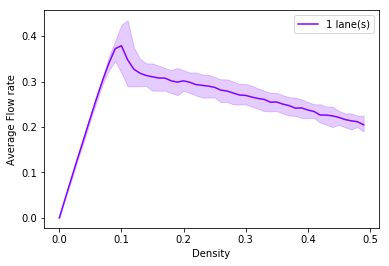

In [139]:
DISPLAY = False

densities = np.arange(0,0.5,0.01)
num_simulations = 100
num_steps = 200
arr_num_lanes = [1]
colors = cm.rainbow(np.linspace(0, 1, len(arr_num_lanes)))

for num_lanes in arr_num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, num_lanes)
    plot_mean_and_CI(*results, colors[num_lanes - 1])

plt.legend()
plt.xlabel('Density')
plt.ylabel('Average Flow rate')
plt.show()

## 2-lane road simulation

In [60]:
DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.5,
    'num_lanes': 2,
    'p_change': 1
}
num_steps = 10

# Running simulation for low traffic density
run_simulation(sim_attributes, num_steps)

# Running simulation for medium density (density = 0.3)
sim_attributes['traffic_density'] = 0.3
run_simulation(sim_attributes, num_steps)

# Running simulation for high density (density = 0.7)
sim_attributes['traffic_density'] = 0.7
run_simulation(sim_attributes, num_steps)

Running simulation for traffic_density: 0.1
Initial State
3..............4..0..................4.........4......5........3...5.....................1....0.....
...........2.....2....................4.........5.......1........52........2....3..................5
--------------------
Simulation Starts
------------------------------
Number of lane changes in this step:  0
....4...........1..1.....................4.........4......4......2.....4...................2..0.....
...4..........3....2......................4.........4....1.......0...3.......2......4...............
--------------------
Number of lane changes in this step:  0
.........5.......1...2.......................4..........5......5....3.......5................2.1....
........5........3...2.........................5.......3...2.....0......3.......3........5..........
--------------------
Number of lane changes in this step:  0
.............4....1....2..........................5..........5.....4....4........5............1.1...
...

### Plotting average flow rate graph for different car densities of 1-lane vs 2-lane road.

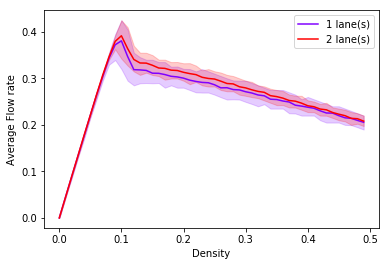

In [23]:
DISPLAY = False

densities = np.arange(0,0.5,0.01)
num_simulations = 100
num_steps = 200
arr_num_lanes = [1, 2]
colors = cm.rainbow(np.linspace(0, 1, len(arr_num_lanes)))

for num_lanes in arr_num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, num_lanes)
    plot_mean_and_CI(*results, colors[num_lanes - 1])

plt.legend()
plt.xlabel('Density')
plt.ylabel('Average Flow rate')
plt.show()

## 3-lanes road simulation

In [62]:
DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.5,
    'num_lanes': 3,
    'p_change': 1
}
num_steps = 10

# Running simulation for low traffic density
run_simulation(sim_attributes, num_steps)

# Running simulation for medium density (density = 0.3)
sim_attributes['traffic_density'] = 0.3
run_simulation(sim_attributes, num_steps)

# Running simulation for high density (density = 0.7)
sim_attributes['traffic_density'] = 0.7
run_simulation(sim_attributes, num_steps)

Running simulation for traffic_density: 0.1
Initial State
..................................41.0........0......0.........2.........0.4.......4.4..............
.....2.....................5.4...4......2....53...........5...........42............................
.......1..........30.1.......4...............4...............0........4.4.................3.........
--------------------
Simulation Starts
------------------------------
Number of lane changes in this step:  3
...............................4..0.1.1........1......1..........2.......0.....4.........4..........
.......2..............4.........3.....5....3.0....4............5......0..2.............4............
........1..........0...2..........5...............5...........1........1.....5...............3......
--------------------
Number of lane changes in this step:  1
.................................2.10..1........1......1............3.....1........4.........4......
.........2................4.........4.....4...1.......4.........

### Plotting average flow rate graph for different car densities of 1-lane vs 2-lane vs 3-lane roads

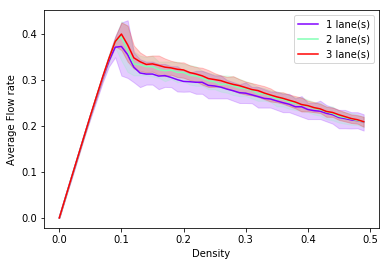

In [25]:
DISPLAY = False

densities = np.arange(0,0.5,0.01)
num_simulations = 100
num_steps = 200
arr_num_lanes = [1, 2, 3]
colors = cm.rainbow(np.linspace(0, 1, len(arr_num_lanes)))

for num_lanes in arr_num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, num_lanes)
    plot_mean_and_CI(*results, colors[num_lanes - 1])

plt.legend()
plt.xlabel('Density')
plt.ylabel('Average Flow rate')
plt.show()

# Extension

In [82]:
class Obstacle:
    '''
        Denotes an obstacle in the road, used for lane merges, or any such things
    '''
    
    def __init__(self):
        '''
            Initializing initial parameters
        '''
        self.speed = 0

In [133]:
class TrafficSimulationExtension(TrafficSimulation):
    '''
        Inherits from TrafficSimulaiton class that simulates the traffic flow in a high way using periodic boundary
        
        
        Attributes:
        ----------------
        * road_length -- The length of the road.
        
        * traffic_density -- The proportion of car per unit length of road
        
        * v_max -- The maximum speed of the car on the road
        
        * p_slow -- The probability of randomly slowing down
        
        * num_lanes -- The number of lanes in the simulation
        
        * p_change -- The probability of changing lanes
        
        * current_state -- (Array) stores current speed and position of cars
        
        * next_state -- (Array) stores next moving location of each cars
        
        * arr_flow -- (Array) stores the flow of cars in each time step
        
        * time_steps -- (int) The number of steps the simulation has run
        
        * pos_traffic_lights (array) stores indexes of points where traffic light is set
        
        * time_traffic_lights (array) stores the light change interval of each traffic lights
        
        
        Inherited Methods:
        ------------------
        * __init__ -- Initializes the attributes
        
        * initialize() -- Initializes all parameters for the simulation
        
        * step() -- Perform the updates for single time step
        
        * _update_speed() -- Updates the speed of cars in each lane based on their gaps ahead
        
        * _update_lanes() -- Updates the lanes of the cars. Moves them to new lane if there are free side lanes
        
        * _get_lane() -- Returns the index of the free lane to place the car
        
        * _check_free_lane -- Checks whether or not a lane is empty.
        
        * calc_flow() --  Calculate and stores the flow of cars after each time step
        
        * calc_avg_flow() -- Calculates the average flow of cars during the simulation
        
        * display() -- Displays the next state of the cars
        
        
        New Methods:
        -----------
        
        * set_obstacle() Creates a obstacle at the given cell
        
        * clear_obstacle() Cleares the obstacle currently at the given point
        
        * set_lane_merge() Creates multiple obstacles to obstruct lanes for lane mergers
        
        * set_speed_limit() Sets the speed limit at the given cell in the road
        
        * set_traffic_lights() Creats a traffic light at given position in the road
        
        * change_traffic_lights() Changes the status of traffic light at a given position
        
    '''
        
    
    def initialize(self):
        '''
            Creates a random distribution of cars for initializing the simulation
        '''
        states = [[-1 for _ in range(self.road_length)] for _ in range(self.num_lanes)]
        self.arr_flow = []
        
        for lane in states:
            cars = np.random.choice(self.road_length, replace=False, 
                        size=int(round(self.road_length * self.traffic_density)))
            
            for ind_car in cars:
                lane[ind_car] = Car(np.random.randint(0, self.v_max + 1), 
                                    self.v_max, self.p_slow, 1) 
        
            
        self.current_state = np.array(states)
        
        # By default setting speed-limits to v_max for all the positions
        self.speed_limits = np.array([[self.v_max for _ in range(self.road_length)] for _ in range(self.num_lanes)])

        
        # Array to store indexes of traffic lights and switch time of traffic lights
        self.pos_traffic_lights = []
        self.time_traffic_lights = []
        self.time_steps = 0
    
    def set_obstacle(self, ind_lane, ind_cell):
        '''
            Creates an obstacle object at certain parts of road.
            For lane merges, obstacles will be created side by side.
            
            Input:
            
            * ind_lane (int) Index of the lane where the obstacle will be created
            
            * ind_cell (int) Index of the cell where the obstacle will be created
        '''
        self.current_state[ind_lane][ind_cell] = Obstacle()
        
    def clear_obstacle(self, ind_lane, ind_cell):
        '''
            Clears the obstacle if there is a obstacle in the given place.
            
            Input:
            
            * ind_lane (int) Index of the lane where the obstacle will be created
            
            * ind_cell (int) Index of the cell where the obstacle will be created
        '''
        if type(self.current_state[ind_lane][ind_cell]) == Obstacle:
            self.current_state[ind_lane][ind_cell] = -1
        else:
            print('No obstacle at that location!!!!!')
        
    def set_lane_merge(self, ind_lane, ind_cell_range):
        '''
            Creates multiple obstacle consecutively to act as lane merges
            
            Input:
            
            * ind_lane (int) Index of the lane to create the lane merge 
            
            * ind_cell_range (array) That stores indexes of the cells to create obstacles
                                    for lane merge
                                
        '''
        
        for ind_cell in ind_cell_range:
            self.current_state[ind_lane][ind_cell] = Obstacle()
    
    def set_speed_limit(self, ind_lane, ind_cell, speed_limit):
        '''
            Updates the speed limits array that stores the maximum speed in each cell of 
            the road.
            
            Input
            
            * ind_lane (int) The index of lane to put speed limit
            
            * ind_cell (int) The index of cell to put speed limit
            
            * speed_limit (int) The speed limit on the choosen cell
        '''
        
        self.speed_limits[ind_lane][ind_cell] = speed_limit

    
    def _get_lane(self, ind_lane, ind_car):
        '''
            Gets the preferred lane to move
            
            Input:
            
            * ind_lane (int) The index of lane the car is currently on
            
            * ind_car (int) The index of the cell of the car in the lane
            
            Output:
            
            (int) The new or updated index for the car to change lanes.
        '''
        
        if type(self.current_state[ind_lane][ind_car]) == Obstacle:
            return ind_lane
        
        lane_options = [] #stores the indexes of side lanes
        
        # Checking the boundary conditions
        if ind_lane > 0:
            lane_options.append(ind_lane - 1)
        
        if ind_lane != self.num_lanes - 1:
            lane_options.append(ind_lane + 1)
            
        free_lanes = [] #stores the free lanes
        for ind_other_lane in lane_options:
            if self._check_free_lane(ind_lane, ind_car, ind_other_lane):
                free_lanes.append(ind_other_lane)
        
        # If there are two free lanes, it will randomly choose one of the lanes
        if len(free_lanes) > 0:
            return np.random.choice(free_lanes)
        
        return ind_lane
    
    
    def set_traffic_lights(self, ind_cell, switch_time):
        '''
            Stores the indexes for the position of traffic lights and their changing interval
            
            Input:
            
            * ind_cell (int) Index of the cell in the traffic lights
            
            * switch_time (int) The time for switching the traffic lights
        '''
        self.pos_traffic_lights.append(ind_cell)
        self.time_traffic_lights.append(switch_time)
        
    
    def change_traffic_lights(self, ind_cell):
        '''
            Changes the color of traffic lights at a given position.
            It assumes the traffic light is applicable to all the lanes in the road.

            Input:

            * ind_cell (int) The index of the traffic light
        '''
        if self.speed_limits[0][ind_cell] == 0:
            state = self.v_max
        else:
            state = 0

        # Looping to change the speed limits in each lane
        for i in range(self.num_lanes):
            self.set_speed_limit(i, ind_cell, state)

    
    def _update_speed(self):
        '''
            Performs independent update of speeds in each lane and moves cars 
            front based on the velocity
        '''
        
        next_state = [] # Temporary array to store the new state
        
        ind_lane = 0
        for lane in self.current_state:
            arr_ind_cars = np.where(lane != -1)[0]
            
            for i in arr_ind_cars:
                if type(lane[i]) != Obstacle:
                    
                    speed = lane[i].speed
                    
                    # Accelerate if speed < v_max
                    if speed < lane[i].v_max:
                        speed += 1
                    
                    # Decelerate based on neighborhood
                    for gap in range(1, speed + 1):
                        if lane[(i + gap) % self.road_length] != -1:
                            gap = gap - 1
                            break
                        elif speed > self.speed_limits[ind_lane][(i + gap) % self.road_length]:
                            gap = self.speed_limits[ind_lane][(i + gap) % self.road_length] 
                            break
                    speed = gap

                    # Randomized slow downs
                    if (np.random.uniform() < lane[i].p_slow) and (speed > 0):
                        speed -= 1
                            
                    if speed > self.speed_limits[ind_lane][i]:
                        speed = self.speed_limits[ind_lane][i]
                    
                    lane[i].sts_lane_change = False
                    lane[i].set_speed(speed)
            
            ind_lane += 1
            
            # Moving cars
            next_step_lane = [-1 for _ in range(self.road_length)]
            for i in arr_ind_cars:
                next_step_lane[(i + lane[i].speed) % self.road_length] = lane[i]
                
            next_state.append(next_step_lane)
        
        self.current_state = np.array(next_state)
    
    def step(self):
        '''
            Updates one time step in the simulation
        '''
        # Checking for changing traffic lights
        for i in range(len(self.time_traffic_lights)):
            if self.time_steps % self.time_traffic_lights[i] == 0:
                self.change_traffic_lights(self.pos_traffic_lights[i])
                
        if self.num_lanes > 1:
            # If there are more than one lanes, then check for lane changes.
            self._update_lanes()
        
        # Updating the speed independently
        self._update_speed()
        
        
        if DISPLAY:
            self.display()
        
        # Calculating the flow at current time step
        self.calc_flow()
        
        # Adding the time steps
        self.time_steps += 1
        
        
        
    def display(self):
        '''
            Displays current state of the cars in the roads.
            The number represent cars and their speed.
            'X' represents a obstacle.
            Lane merges are shown by consecutive 'X'
            
            The speed limits are shown in the last line. If the speed limit
            is equal to maximum which represents max flow it is shown by '_',
            if there is a lower limit, the speed limit is displayed as  number.
            
            For traffic lights, it switches between '_' and '0', which represents 
            green and red light consecutively.
        '''
        for lane in self.current_state:
            print(''.join(['.' if x == -1 else str(x.speed) if type(x)==Car else 'X' for x in lane]))
            
        # printing traffic lights and speed limits.
        print(''.join(['_' if x==5 else str(x) for x in self.speed_limits[1]]) + '-> Speed limits/Traffic Lights')
        print('-'*20)

### Simulation with obstacles at two different point

In [134]:
np.random.seed(5)

DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.2,
    'num_lanes': 3,
    'p_change': 1
}

num_steps = 10

sim = TrafficSimulationExtension(**sim_attributes)

print('Initial State')
sim.display()

# setting obstacles at empty locations as the obstacle will replace the cars.
# Need to check before keeping the obstacle unless its a broken car.
print('Creating Obstacles')
sim.set_obstacle(1, 32)
sim.set_obstacle(0, 50)

# Setting up two obstacles
sim.display()

print('Simulation Starts:')
for i in range(7):
    sim.step()

Initial State
..........4......5..3..2....4...5..0..........1...................3.......5.........................
......5....2..............3.524......5..................1.....1.....................2...............
...........................1......5........4.......0.......2.....5.1..1.............4....2..........
____________________________________________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Creating Obstacles
..........4......5..3..2....4...5..0..........1...X...............3.......5.........................
......5....2..............3.524.X....5..................1.....1.....................2...............
...........................1......5........4.......0.......2.....5.1..1.............4....2..........
____________________________________________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Simulation Starts:
Number of lane changes in this step:  

### Simulation for lane merges due to bridge

In [137]:
DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.2,
    'num_lanes': 3,
    'p_change': 1
}

num_steps = 10

sim = TrafficSimulationExtension(**sim_attributes)

print('Initial State')
sim.display()

# setting obstacles at empty locations as the obstacle will replace the cars.
# Need to check before keeping the obstacle unless its a broken car.
print('Creating lane merges')

arr_cell_index = [i for i in range(sim.road_length)]

# lane merge to happen in the middle of highway because it is a bridge
sim.set_lane_merge(0, arr_cell_index[30:60])
sim.set_lane_merge(2, arr_cell_index[30:60])

# Setting up two obstacles
sim.display()

print('Simulation Starts:')
for i in range(5):
    sim.step()
    
# Simulating multiple times for average flow rate
DISPLAY = False
for i in range(200):
    sim.step()
print('Average flow rate is {:.2f} after 200 steps'.format(sim.calc_avg_flow()))

Initial State
.5................5..2.......5..........3..................2............3............4........4.5...
..........3.................3..........3.15.01............................2.............1...3.......
..2.................1...........................1........2.............4............2.......34...23.
____________________________________________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Creating lane merges
.5................5..2.......5XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX............3............4........4.5...
..........3.................3..........3.15.01............................2.............1...3.......
..2.................1.........XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...........4............2.......34...23.
____________________________________________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Simulation Starts:
Number of lane changes in this step:

### Simulation for traffic lights
The traffic lights is fixed at position 30 of road length 100 for this simulation. The traffic light changes color at every 4 timesteps. The traffic light applies to all the lanes in the road.

In [138]:
np.random.seed(5)

DISPLAY = True
sim_attributes = {
    'road_length': 100,
    'traffic_density': 0.1,
    'v_max': 5,
    'p_slow': 0.2,
    'num_lanes': 3,
    'p_change': 1
}

num_steps = 10

sim = TrafficSimulationExtension(**sim_attributes)


# Setting a traffic light at cell index 30 with switch time 4
sim.set_traffic_lights(30, 4)

print('Initial State')
sim.display()

for i in range(num_steps):
    sim.step()

Initial State
..........4......5..3..2....4...5..0..........1...................3.......5.........................
......5....2..............3.524......5..................1.....1.....................2...............
...........................1......5........4.......0.......2.....5.1..1.............4....2..........
____________________________________________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Number of lane changes in this step:  3
...............5..........3.0.....2.1...........2.....................4........5....................
..............3....2....4..1000...........5...............2.....2.....................2.............
...........5.................2.........5........5...1.........3...1..2..2...............4..2........
______________________________0_____________________________________________________________________-> Speed limits/Traffic Lights
--------------------
Number of lane changes in this step:

Extensions to the traffic model to make it more realistic:

- Crossing lanes
- Priority cars (ambulance)
- Multiple lanes
    - With different speed in different lanes
- Weather conditions
- Intersections (Traffic lights)
- Fixed/Open boundaries
- Bi-directional roads
- Different times with different traffic density
- Some slower cars driven by old drivers (different maximum velocity)
- Two cells if there is a truck (complicated rules)
- Distracted drivers
    - Accidents
- Obstacles:
    - Animal crossing roads
    - Accidents
    - Police stops
    - Car breakdowns

## Resources
https://studywolf.wordpress.com/2017/11/21/matplotlib-legends-for-mean-and-confidence-interval-plots/

- Slow cars on the left
- Overtake only from one side
- Create a Car class
    - Give attributes of speed
    - Low max 
- Gives attributes of bad driver
    - L_back = 0
- Going over the speed limit
- Overtakes car from the right also

If you go on the left, low speed?
- The speed limit should be defined at every cell so that different parts of the road can have different speed limits. 
- Create another list of the same size as current_state with same dimensions or same length and lanes
- Each element will be the max speed in that cell.
- Compare your next move with max speed in that cell.
- This allows you to model how a change in the speed limit at a point in the road affects traffic at, before and after that point.
- Traffic lights can be modeled as a temporary speed limit of 0 on a portion of the road, changing to and from the normal speed limit at regular intervals. 
- Store one more array, with indexes for traffic lights
- Obstacles are like having a permanent stationary car at a particular cell. 
- Put a permanent car with speed zero
- In each timestep, ignore the change in speed for that car.
Model how cars have to go around an obstacle (e.g. accident) in the road. Lane merges can be modeled as a very long obstacle blocking a lane. Simulate, visualize and analyze the effects of speed limit changes, traffic lights, obstacles, and lane merges on traffic flow.
